#  Build a Research Agent with LangGraph, GPT-4o, RAG, Pinecone, ArXiv and Google SerpAPI

### Install Required Libraries

In [3]:
!pip install -r requirements.txt -q

In [4]:
!pip install semantic_router -q

###  Extracting Data from ArXiv into a Pandas DataFrame and Saving it as JSON

In [8]:
import requests
import pandas as pd
import json
import xml.etree.ElementTree as ET

ARXIV_NAMESPACE = '{http://www.w3.org/2005/Atom}'

def extract_from_arxiv(search_query='cat:cs.AI', max_results=100, json_file_path='files/arxiv_dataset.json'):
    """
    Fetches papers from the ArXiv API based on a search query, saves them as JSON, 
    and returns a pandas DataFrame.

    Args:
        search_query (str): The search query for ArXiv (default is 'cat:cs.AI').
        max_results (int): The maximum number of results to retrieve (default is 100).
        json_file_path (str): File path where JSON data will be saved.

    Returns:
        pd.DataFrame: DataFrame containing the extracted paper information.
    """
    
    url = f'http://export.arxiv.org/api/query?search_query={search_query}&max_results={max_results}'
    
    response = requests.get(url)
    
    root = ET.fromstring(response.content)
    
    papers = []
    
    for entry in root.findall(f'{ARXIV_NAMESPACE}entry'):
        title = entry.find(f'{ARXIV_NAMESPACE}title').text.strip()
        summary = entry.find(f'{ARXIV_NAMESPACE}summary').text.strip()

        author_elements = entry.findall(f'{ARXIV_NAMESPACE}author')
        authors = [author.find(f'{ARXIV_NAMESPACE}name').text for author in author_elements]

        paper_url = entry.find(f'{ARXIV_NAMESPACE}id').text
        arxiv_id = paper_url.split('/')[-1]

        pdf_link = next((link.attrib['href'] for link in entry.findall(f'{ARXIV_NAMESPACE}link') 
                         if link.attrib.get('title') == 'pdf'), None)

        papers.append({
            'title': title,
            'summary': summary,
            'authors': authors,
            'arxiv_id': arxiv_id,
            'url': paper_url,
            'pdf_link': pdf_link
        })
    
    df = pd.DataFrame(papers)
    
    with open(json_file_path, 'w', encoding='utf-8') as f:
        json.dump(papers, f, ensure_ascii=False, indent=4)
        print(f'Data saved to {json_file_path} ...')
    
    return df

### Testing the function

In [11]:
df = extract_from_arxiv(max_results=20)

Data saved to files/arxiv_dataset.json ...


In [13]:
import json
file_name = 'files/arxiv_dataset.json'
with  open(file_name, 'r') as file:
    data = json.load(file)

print(data)

[{'title': 'Dynamic Backtracking', 'summary': 'Because of their occasional need to return to shallow points in a search\ntree, existing backtracking methods can sometimes erase meaningful progress\ntoward solving a search problem. In this paper, we present a method by which\nbacktrack points can be moved deeper in the search space, thereby avoiding this\ndifficulty. The technique developed is a variant of dependency-directed\nbacktracking that uses only polynomial space while still providing useful\ncontrol information and retaining the completeness guarantees provided by\nearlier approaches.', 'authors': ['M. L. Ginsberg'], 'arxiv_id': '9308101v1', 'url': 'http://arxiv.org/abs/cs/9308101v1', 'pdf_link': 'http://arxiv.org/pdf/cs/9308101v1'}, {'title': 'A Market-Oriented Programming Environment and its Application to\n  Distributed Multicommodity Flow Problems', 'summary': 'Market price systems constitute a well-understood class of mechanisms that\nunder certain conditions provide effec

In [15]:
import pandas as pd
df = pd.DataFrame(data)
df.sample(n=5)

,title,summary,authors,arxiv_id,url,pdf_link
5,Decidable Reasoning in Terminological Knowledg...,Terminological knowledge representation system...,"[M. Buchheit, F. M. Donini, A. Schaerf]",9312101v1,http://arxiv.org/abs/cs/9312101v1,http://arxiv.org/pdf/cs/9312101v1
9,Bias-Driven Revision of Logical Domain Theories,The theory revision problem is the problem of ...,"[M. Koppel, R. Feldman, A. M. Segre]",9402103v1,http://arxiv.org/abs/cs/9402103v1,http://arxiv.org/pdf/cs/9402103v1
11,A Semantics and Complete Algorithm for Subsump...,This paper analyzes the correctness of the sub...,"[A. Borgida, P. F. Patel-Schneider]",9406101v1,http://arxiv.org/abs/cs/9406101v1,http://arxiv.org/pdf/cs/9406101v1
6,Teleo-Reactive Programs for Agent Control,A formalism is presented for computing and org...,[N. Nilsson],9401101v1,http://arxiv.org/abs/cs/9401101v1,http://arxiv.org/pdf/cs/9401101v1
3,The Difficulties of Learning Logic Programs wi...,As real logic programmers normally use cut (!)...,"[F. Bergadano, D. Gunetti, U. Trinchero]",9311101v1,http://arxiv.org/abs/cs/9311101v1,http://arxiv.org/pdf/cs/9311101v1


#### Downloading Research Papers (PDFs)

In [18]:
import pandas as pd
import requests
import os

def download_pdfs(df, download_folder='files'):
    """
        Retrieves and stores academic papers from ArXiv as PDF files using URLs provided in a DataFrame.
        This function processes each paper systematically, handling potential download failures gracefully,
        and maintains a record of file locations for subsequent processing.
    
        Parameters
        ----------
        df : pandas.DataFrame
            Input DataFrame containing paper metadata with a required 'pdf_link' column 
            storing ArXiv PDF URLs.
        download_folder : str, optional
            Target directory for PDF storage (default: 'files'). Will be created if 
            it doesn't exist.
    
        Returns
        -------
        pandas.DataFrame
            Enhanced DataFrame with an additional 'pdf_file_name' column containing:
            - Full file paths for successfully downloaded PDFs
            - None values for failed downloads
            
        Notes
        -----
        The function implements error handling for network issues and invalid URLs,
        ensuring the process continues even if individual downloads fail.
    """
    
    if not os.path.exists(download_folder):
        os.makedirs(download_folder)
    
    pdf_file_names = []
    
    for index, row in df.iterrows():
        pdf_link = row['pdf_link']
        
        try:
            response = requests.get(pdf_link)
            response.raise_for_status()
    
            file_name = os.path.join(download_folder, pdf_link.split('/')[-1]) + '.pdf'
            pdf_file_names.append(file_name)
    
            with open(file_name, 'wb') as f:
                f.write(response.content)
            
            print(f'PDF downloaded successfully and saved as {file_name}')
        
        except requests.exceptions.RequestException as e:
            print(f'Failed to download the PDF: {e}')
            pdf_file_names.append(None)
    
    df['pdf_file_name'] = pdf_file_names

    return df

In [20]:
df = download_pdfs(df)

PDF downloaded successfully and saved as files/9308101v1.pdf
PDF downloaded successfully and saved as files/9308102v1.pdf
PDF downloaded successfully and saved as files/9309101v1.pdf
PDF downloaded successfully and saved as files/9311101v1.pdf
PDF downloaded successfully and saved as files/9311102v1.pdf
PDF downloaded successfully and saved as files/9312101v1.pdf
PDF downloaded successfully and saved as files/9401101v1.pdf
PDF downloaded successfully and saved as files/9402101v1.pdf
PDF downloaded successfully and saved as files/9402102v1.pdf
PDF downloaded successfully and saved as files/9402103v1.pdf
PDF downloaded successfully and saved as files/9403101v1.pdf
PDF downloaded successfully and saved as files/9406101v1.pdf
PDF downloaded successfully and saved as files/9406102v1.pdf
PDF downloaded successfully and saved as files/9408101v1.pdf
PDF downloaded successfully and saved as files/9408102v1.pdf
PDF downloaded successfully and saved as files/9408103v1.pdf
PDF downloaded successfu

In [22]:
df

,title,summary,authors,arxiv_id,url,pdf_link,pdf_file_name
0,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,http://arxiv.org/pdf/cs/9308101v1,files/9308101v1.pdf
1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,[M. P. Wellman],9308102v1,http://arxiv.org/abs/cs/9308102v1,http://arxiv.org/pdf/cs/9308102v1,files/9308102v1.pdf
2,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,"[I. P. Gent, T. Walsh]",9309101v1,http://arxiv.org/abs/cs/9309101v1,http://arxiv.org/pdf/cs/9309101v1,files/9309101v1.pdf
3,The Difficulties of Learning Logic Programs wi...,As real logic programmers normally use cut (!)...,"[F. Bergadano, D. Gunetti, U. Trinchero]",9311101v1,http://arxiv.org/abs/cs/9311101v1,http://arxiv.org/pdf/cs/9311101v1,files/9311101v1.pdf
4,Software Agents: Completing Patterns and Const...,To support the goal of allowing users to recor...,"[J. C. Schlimmer, L. A. Hermens]",9311102v1,http://arxiv.org/abs/cs/9311102v1,http://arxiv.org/pdf/cs/9311102v1,files/9311102v1.pdf
5,Decidable Reasoning in Terminological Knowledg...,Terminological knowledge representation system...,"[M. Buchheit, F. M. Donini, A. Schaerf]",9312101v1,http://arxiv.org/abs/cs/9312101v1,http://arxiv.org/pdf/cs/9312101v1,files/9312101v1.pdf
6,Teleo-Reactive Programs for Agent Control,A formalism is presented for computing and org...,[N. Nilsson],9401101v1,http://arxiv.org/abs/cs/9401101v1,http://arxiv.org/pdf/cs/9401101v1,files/9401101v1.pdf
7,Learning the Past Tense of English Verbs: The ...,Learning the past tense of English verbs - a s...,[C. X. Ling],9402101v1,http://arxiv.org/abs/cs/9402101v1,http://arxiv.org/pdf/cs/9402101v1,files/9402101v1.pdf
8,Substructure Discovery Using Minimum Descripti...,The ability to identify interesting and repeti...,"[D. J. Cook, L. B. Holder]",9402102v1,http://arxiv.org/abs/cs/9402102v1,http://arxiv.org/pdf/cs/9402102v1,files/9402102v1.pdf
9,Bias-Driven Revision of Logical Domain Theories,The theory revision problem is the problem of ...,"[M. Koppel, R. Feldman, A. M. Segre]",9402103v1,http://arxiv.org/abs/cs/9402103v1,http://arxiv.org/pdf/cs/9402103v1,files/9402103v1.pdf


### Loading and Splitting PDF Files into Chunks, Expanding the DataFrame

In [25]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

def load_and_chunk_pdf(pdf_file_name, chunk_size=512):
    """
    Processes PDF documents into semantically meaningful text chunks for AI analysis.
    
    This function handles the extraction of text from PDFs and implements intelligent
    text splitting to preserve context and meaning. It uses LangChain's document 
    processing capabilities for robust PDF handling.

    Parameters
    ----------
    pdf_file_name : str
        Path to the target PDF file for processing
    chunk_size : int, optional
        Maximum character length for each text chunk (default: 512)
        Chosen to optimize for transformer model context windows

    Returns
    -------
    List[Document]
        Collection of LangChain Document objects, each containing:
        - Chunk text content
        - Metadata from the original PDF
        - Page numbers and positions
    
    Notes
    -----
    The chunking process includes a 64-character overlap between segments
    to maintain context and prevent splitting of important phrases or concepts.
    """

    print(f'Loading and splitting into chunks: {pdf_file_name}')

    loader = PyPDFLoader(pdf_file_name)
    data = loader.load()

    text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=64)
    chunks = text_splitter.split_documents(data)

    return chunks

/opt/anaconda3/lib/python3.11/site-packages/pydantic/plugin/_loader.py:49: UserWarning: ImportError while loading the `logfire-plugin` Pydantic plugin, this plugin will not be installed.

ImportError("cannot import name 'OTEL_EXPORTER_OTLP_CLIENT_CERTIFICATE' from 'opentelemetry.sdk.environment_variables' (/opt/anaconda3/lib/python3.11/site-packages/opentelemetry/sdk/environment_variables.py)")
  warnings.warn(


In [26]:
def expand_df(df):
    """
    Expands a DataFrame of PDF metadata into a structured collection of text chunks
    with preserved relationships and context.
    
    This function processes each PDF document into chunks while maintaining the
    relationships between segments and their associated metadata. It creates a
    traceable chain of text segments that preserves the document's logical flow.

    Parameters
    ----------
    df : pandas.DataFrame
        Input DataFrame containing document metadata with required columns:
        - pdf_file_name: Path to PDF file
        - arxiv_id: Unique identifier for the paper
        - title: Paper title
        - summary: Paper abstract
        - authors: List of authors
        - url: Source URL

    Returns
    -------
    pandas.DataFrame
        Expanded DataFrame where each row represents a document chunk with:
        - Unique chunk identifiers
        - Complete paper metadata
        - Chunk content
        - References to adjacent chunks (previous/next)
    
    Notes
    -----
    The expansion process creates bidirectional links between chunks,
    enabling reconstruction of the original document flow and context-aware
    processing in the AI pipeline.
    """

    expanded_rows = []  

    for idx, row in df.iterrows():
        try:
            chunks = load_and_chunk_pdf(row['pdf_file_name'])
        except Exception as e:
            print(f"Error processing file {row['pdf_file_name']}: {e}")
            continue

        for i, chunk in enumerate(chunks):
            prechunk_id = i-1 if i > 0 else ''  
            postchunk_id = i+1 if i < len(chunks) - 1 else ''  

            expanded_rows.append({
                'id': f"{row['arxiv_id']}#{i}",  
                'title': row['title'],
                'summary': row['summary'],
                'authors': row['authors'],
                'arxiv_id': row['arxiv_id'],
                'url': row['url'],
                'chunk': chunk.page_content,  
                'prechunk_id': '' if i == 0 else f"{row['arxiv_id']}#{prechunk_id}",  
                'postchunk_id': '' if i == len(chunks) - 1 else f"{row['arxiv_id']}#{postchunk_id}" 
            })

    return pd.DataFrame(expanded_rows)


In [29]:
expanded_df = expand_df(df)

Loading and splitting into chunks: files/9308101v1.pdf
Loading and splitting into chunks: files/9308102v1.pdf
Loading and splitting into chunks: files/9309101v1.pdf
Loading and splitting into chunks: files/9311101v1.pdf
Loading and splitting into chunks: files/9311102v1.pdf
Loading and splitting into chunks: files/9312101v1.pdf
Loading and splitting into chunks: files/9401101v1.pdf
Loading and splitting into chunks: files/9402101v1.pdf
Loading and splitting into chunks: files/9402102v1.pdf
Loading and splitting into chunks: files/9402103v1.pdf
Loading and splitting into chunks: files/9403101v1.pdf
Loading and splitting into chunks: files/9406101v1.pdf
Loading and splitting into chunks: files/9406102v1.pdf
Loading and splitting into chunks: files/9408101v1.pdf


Illegal character in Name Object (b'/\x84')
Illegal character in Name Object (b'/\x84')
Illegal character in Name Object (b'/\xd8')
Illegal character in Name Object (b'/\xd8')
Illegal character in Name Object (b'/\x99')
Illegal character in Name Object (b'/\x99')
Illegal character in Name Object (b'/\x8f')
Illegal character in Name Object (b'/\x8f')
Illegal character in Name Object (b'/\xb9')
Illegal character in Name Object (b'/\xb9')
Illegal character in Name Object (b'/\xda')
Illegal character in Name Object (b'/\xaa')
Illegal character in Name Object (b'/\xaa')
Illegal character in Name Object (b'/\xda')
Illegal character in Name Object (b'/\xd2')
Illegal character in Name Object (b'/\xd2')
Illegal character in Name Object (b'/\xb1')
Illegal character in Name Object (b'/\x99')
Illegal character in Name Object (b'/\x99')
Illegal character in Name Object (b'/\xb1')
Illegal character in Name Object (b'/\xb5')
Illegal character in Name Object (b'/\xfd')
Illegal character in Name Object

Loading and splitting into chunks: files/9408102v1.pdf


Illegal character in Name Object (b'/\xd9')
Illegal character in Name Object (b'/\xae')
Illegal character in Name Object (b'/\x94')
Illegal character in Name Object (b'/\x9e')
Illegal character in Name Object (b'/\x94')
Illegal character in Name Object (b'/\x9e')
Illegal character in Name Object (b'/\xae')


Loading and splitting into chunks: files/9408103v1.pdf
Loading and splitting into chunks: files/9409101v1.pdf
Loading and splitting into chunks: files/9412101v1.pdf
Loading and splitting into chunks: files/9412102v1.pdf
Loading and splitting into chunks: files/9412103v1.pdf


In [31]:
expanded_df

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,9308101v1#0,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,Journal of Arti/ cial In telligence Researc h ...,,9308101v1#1
1,9308101v1#1,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,"In this pap er/, w e presen t a metho d b y wh...",9308101v1#0,9308101v1#2
2,9308101v1#2,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,to solv e some constrain t/-satisfaction probl...,9308101v1#1,9308101v1#3
3,9308101v1#3,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,"try /, coloring p erhaps half a dozen of them ...",9308101v1#2,9308101v1#4
4,9308101v1#4,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,states/.W e successfully color the eastern sta...,9308101v1#3,9308101v1#5
...,...,...,...,...,...,...,...,...,...
4778,9412103v1#281,Total-Order and Partial-Order Planning: A Comp...,"For many years, the intuitions underlying part...","[S. Minton, J. Bresina, M. Drummond]",9412103v1,http://arxiv.org/abs/cs/9412103v1,"UCPOP /: A sound/, complete/, partial/-order p...",9412103v1#280,9412103v1#282
4779,9412103v1#282,Total-Order and Partial-Order Planning: A Comp...,"For many years, the intuitions underlying part...","[S. Minton, J. Bresina, M. Drummond]",9412103v1,http://arxiv.org/abs/cs/9412103v1,"ligenc e /, pp/. /1/0/0/{/1/1/1 SanktAugustin/...",9412103v1#281,9412103v1#283
4780,9412103v1#283,Total-Order and Partial-Order Planning: A Comp...,"For many years, the intuitions underlying part...","[S. Minton, J. Bresina, M. Drummond]",9412103v1,http://arxiv.org/abs/cs/9412103v1,"Minton/, Bresina/, /& Dr ummondSacerdoti/, E/....",9412103v1#282,9412103v1#284
4781,9412103v1#284,Total-Order and Partial-Order Planning: A Comp...,"For many years, the intuitions underlying part...","[S. Minton, J. Bresina, M. Drummond]",9412103v1,http://arxiv.org/abs/cs/9412103v1,"Univ/. of Edin burgh/, Mac hine In telligenceR...",9412103v1#283,9412103v1#285


### Building a Knowledge Base for the RAG System Using Embedding

In [38]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv(), override=True)

True

In [48]:
import os
from getpass import getpass
from openai import OpenAI  

# Check if 'OPENAI_API_KEY' is set; prompt if not
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY') or getpass('OpenAI API key: ')

# Initialize the OpenAI client
client = OpenAI()

# Create a test embedding
test_text = "hello hallo hola salut"
response = client.embeddings.create(
    model="text-embedding-3-small",
    input=test_text
)

# Get embedding dimensions
dims = len(response.data[0].embedding)
print(f"Embedding dimensions: {dims}")

Embedding dimensions: 1536


In [156]:
pip install semantic-router -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.7.0 requires botocore<1.31.65,>=1.31.16, but you have botocore 1.34.19 which is incompatible.
conda-repo-cli 1.0.75 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.75 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [158]:
import os
from getpass import getpass

from semantic_router.encoders import OpenAIEncoder

# Check if 'OPENAI_API_KEY' is set; prompt if not
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY') or getpass('OpenAI API key: ')

# Initialize the OpenAIEncoder with a specific model
encoder = OpenAIEncoder(name='text-embedding-3-small')

In [160]:
encoder('hello hallo hola salut')

[[0.013671690598130226,
  0.006499175913631916,
  0.01935115084052086,
  0.03015383519232273,
  0.01522329542785883,
  0.0020547788590192795,
  -0.003178228856995702,
  0.05105658993124962,
  -0.015413586981594563,
  -0.05006122216582298,
  0.01284465566277504,
  -0.0015177552122622728,
  -0.07096397876739502,
  -0.0045523508451879025,
  0.024532925337553024,
  0.012947119772434235,
  -0.024005966261029243,
  -0.0033136282581835985,
  0.014235245063900948,
  0.04151275381445885,
  -0.0209320317953825,
  0.03372545540332794,
  0.04121999815106392,
  0.039287813007831573,
  0.007403059396892786,
  -0.009397457353770733,
  -0.010502610355615616,
  -0.013993721455335617,
  0.02889498509466648,
  -0.01554532628506422,
  0.034691549837589264,
  -0.03275936096906662,
  0.02715308964252472,
  -0.029246293008327484,
  -0.007743387948721647,
  0.04420610889792442,
  -0.04935860633850098,
  0.04321073740720749,
  -0.026889609172940254,
  0.022791029885411263,
  -0.010326956398785114,
  0.00018537

In [162]:
dims = len(encoder('hello hallo hola salut')[0])
dims

1536

### Creating the Pinecone Index

In [51]:
from pinecone import Pinecone, ServerlessSpec

api_key = os.getenv('PINECONE_API_KEY') or getpass('Pinecone API key: ')

pc = Pinecone(api_key=api_key)

spec = ServerlessSpec(
    cloud='aws', 
    region='us-east-1'
)

In [53]:
import time

index_name = 'langgraph-research-agent'

if index_name not in pc.list_indexes().names():
    pc.create_index(
        index_name,
        dimension=dims,  # Embedding dimension (1536)
        metric='cosine',
        spec=spec 
    )

    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

index = pc.Index(index_name)

time.sleep(1)

index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 4783}},
 'total_vector_count': 4783}

### Populating the knowledge base and uploading it to Pinecone

In [55]:
expanded_df.iloc[:5]

,id,title,summary,authors,arxiv_id,url,chunk,prechunk_id,postchunk_id
0,9308101v1#0,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,Journal of Arti/ cial In telligence Researc h ...,,9308101v1#1
1,9308101v1#1,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,"In this pap er/, w e presen t a metho d b y wh...",9308101v1#0,9308101v1#2
2,9308101v1#2,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,to solv e some constrain t/-satisfaction probl...,9308101v1#1,9308101v1#3
3,9308101v1#3,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,"try /, coloring p erhaps half a dozen of them ...",9308101v1#2,9308101v1#4
4,9308101v1#4,Dynamic Backtracking,Because of their occasional need to return to ...,[M. L. Ginsberg],9308101v1,http://arxiv.org/abs/cs/9308101v1,states/.W e successfully color the eastern sta...,9308101v1#3,9308101v1#5


In [86]:
from tqdm.auto import tqdm
data = expanded_df
batch_size = 64  

for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i + batch_size)  
    batch = data[i:i_end].to_dict(orient='records')  
    
    metadata = [{
        'arxiv_id': r['arxiv_id'],
        'title': r['title'],
        'chunk': r['chunk'],
    } for r in batch]
    
    ids = [r['id'] for r in batch]
    
    chunks = [r['chunk'] for r in batch]
    
    response = client.embeddings.create(
        model="text-embedding-3-small",
        input=chunks
    )
    embeds = [e.embedding for e in response.data]
    
    index.upsert(vectors=zip(ids, embeds, metadata))

  0%|          | 0/75 [00:00<?, ?it/s]

In [58]:
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 4783}},
 'total_vector_count': 4783}

# Episode 04

### Segment 1: Creating the ArXiv Fetch Tool

In [62]:
import requests
arxiv_id = '2502.20384'
res = requests.get(f'https://arxiv.org/abs/{arxiv_id}')

res.text

'<!DOCTYPE html>\n<html lang="en">\n\n<head>  <title>[2502.20384] Linear matter density perturbations in the $Λ_{\\rm s}$CDM model: Examining growth dynamics and addressing the $S_8$ tension</title>\n  <meta name="viewport" content="width=device-width, initial-scale=1">\n  <link rel="apple-touch-icon" sizes="180x180" href="/static/browse/0.3.4/images/icons/apple-touch-icon.png">\n  <link rel="icon" type="image/png" sizes="32x32" href="/static/browse/0.3.4/images/icons/favicon-32x32.png">\n  <link rel="icon" type="image/png" sizes="16x16" href="/static/browse/0.3.4/images/icons/favicon-16x16.png">\n  <link rel="manifest" href="/static/browse/0.3.4/images/icons/site.webmanifest">\n  <link rel="mask-icon" href="/static/browse/0.3.4/images/icons/safari-pinned-tab.svg" color="#5bbad5">\n  <meta name="msapplication-TileColor" content="#da532c">\n  <meta name="theme-color" content="#ffffff">\n  <link rel="stylesheet" type="text/css" media="screen" href="/static/browse/0.3.4/css/arXiv.css?v=20

In [64]:
import re

abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

re_match = abstract_pattern.search(res.text)

if re_match:
    print(re_match.group(1))
else:
    print('Abstract not found.')

We investigate linear matter density perturbations in the $\Lambda_{\rm s}$CDM, in which the $\Lambda$ is replaced by late-time ($z\sim2$) mirror AdS-dS transition, resulting in distinct growth dynamics. We use two complementary approaches: (i) determining the initial density contrast and its evolution rate for a given collapse scale factor, (ii) computing the collapse scale factor for a specified initial density contrast and evolution rate. We derive analytical solutions for the growth rate $f=\Omega_{\rm m}^\gamma$ and growth index $\gamma$ in both models. Prior to the transition, the AdS-like $\Lambda$ reduces cosmic friction, causing linear matter density perturbations to grow more rapidly than in $\Lambda$CDM; this effect is most pronounced just before the transition, with a growth rate around $15\%$ higher than $\Lambda$CDM around $z\sim2$. After the transition, $\Lambda_{\rm s}$CDM behaves similarly to $\Lambda$CDM but features a larger cosmological constant, leading to higher $

In [66]:
from langchain_core.tools import tool
import requests
import re

abstract_pattern = re.compile(
    r'<blockquote class="abstract mathjax">\s*<span class="descriptor">Abstract:</span>\s*(.*?)\s*</blockquote>',
    re.DOTALL
)

@tool('fetch_arxiv')
def fetch_arxiv(arxiv_id: str) -> str:
    '''Fetches the abstract from an ArXiv paper given its ArXiv ID.

    Args:
        arxiv_id (str): The ArXiv paper ID.
    
    Returns:
        str: The extracted abstract text from the ArXiv paper.
    '''

    res = requests.get(f'https://arxiv.org/abs/{arxiv_id}')
    
    re_match = abstract_pattern.search(res.text)

    return re_match.group(1) if re_match else 'Abstract not found.'


In [70]:
arxiv_id = '2502.20384'
output = fetch_arxiv.invoke(input={'arxiv_id': arxiv_id})
print(output)

We investigate linear matter density perturbations in the $\Lambda_{\rm s}$CDM, in which the $\Lambda$ is replaced by late-time ($z\sim2$) mirror AdS-dS transition, resulting in distinct growth dynamics. We use two complementary approaches: (i) determining the initial density contrast and its evolution rate for a given collapse scale factor, (ii) computing the collapse scale factor for a specified initial density contrast and evolution rate. We derive analytical solutions for the growth rate $f=\Omega_{\rm m}^\gamma$ and growth index $\gamma$ in both models. Prior to the transition, the AdS-like $\Lambda$ reduces cosmic friction, causing linear matter density perturbations to grow more rapidly than in $\Lambda$CDM; this effect is most pronounced just before the transition, with a growth rate around $15\%$ higher than $\Lambda$CDM around $z\sim2$. After the transition, $\Lambda_{\rm s}$CDM behaves similarly to $\Lambda$CDM but features a larger cosmological constant, leading to higher $

### Segment 2: Implementing Web Search with SerpAPI

In [77]:
pip install google-search-results -q


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [79]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv(), override=True)

from serpapi import GoogleSearch
import os
from getpass import getpass

serpapi_params = {
    'engine': 'google',  
    'api_key': os.getenv('SERPAPI_KEY') or getpass('SerpAPI key: ')  # Get the API key securely.
}

search = GoogleSearch({
    **serpapi_params,
    'q': 'water',
    'num': 5
})


results = search.get_dict().get('organic_results', [])

formatted_results = '\n---\n'.join(
    ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results]
)

print(formatted_results)

Water
Water is an inorganic compound with the chemical formula H 2O. It is a transparent, tasteless, odorless, and nearly colorless chemical substance.
https://en.wikipedia.org/wiki/Water
---
Waters Corporation | Laboratory Instruments, Consumables ...
Waters is the leading provider of lab equipment, supplies and software for scientists across the world. Easily research and order everything your lab needs!
https://www.waters.com/nextgen/us/en.html?srsltid=AfmBOoqwmRD4dM-O7W9HsENhYjbcTCNGomAPX6Qd5EjdQrca73u_8-u_
---
Water | H2O | CID 962
Water (chemical formula: H2O) is a transparent fluid which forms the world's streams, lakes, oceans and rain, and is the major constituent of the fluids of ...
https://pubchem.ncbi.nlm.nih.gov/compound/Water


In [81]:
from serpapi import GoogleSearch

@tool('web_search')
def web_search(query: str) -> str:
    '''Finds general knowledge information using a Google search.

    Args:
        query (str): The search query string.
    
    Returns:
        str: A formatted string of the top search results, including title, snippet, and link.
    '''

    search = GoogleSearch({
        **serpapi_params,  
        'q': query,        
        'num': 5         
    })
   
    results = search.get_dict().get('organic_results', [])
    formatted_results = '\n---\n'.join(
        ['\n'.join([x['title'], x['snippet'], x['link']]) for x in results]
    )
    
    return formatted_results if results else 'No results found.'

In [83]:
output = web_search.invoke(input={'query': 'water on mars'})
print(output)

Water on Mars
Mars contains water, though mostly as subsurface permafrost. Surface water is readily visible at some places, such as the ice-filled Korolev Crater, near the ...
https://en.wikipedia.org/wiki/Water_on_Mars
---
Clear evidence of liquid water, not just frozen ice, found on ...
The presence of liquid water suggests that Mars once had a significantly thicker atmosphere that was capable of sustaining warmer temperatures.
https://www.earth.com/news/wave-ripples-discovered-mars-surface-indicate-liquid-water-present-4-billion-years-ago/
---
Scientists find oceans of water on Mars. It's just too deep to ...
A new analysis of Mars' interior suggests that much of the liquid water still exists in the pores of rocks 10-20 kilometers below the surface.
https://news.berkeley.edu/2024/08/12/scientists-find-oceans-of-water-on-mars-its-just-too-deep-to-tap/
---
Water - Mars Education - Arizona State University
Mars today has four known sources, or "reservoirs," of water, according to scien

### Segment 3: Creating RAG Tools for Retrieval-Augmented Generation

In [86]:
def format_rag_contexts(matches: list) -> str:
    '''Formats the retrieved context matches into a readable string format.

    Args:
        matches (list): A list of matched documents with metadata.
    
    Returns:
        str: A formatted string of document titles, chunks, and ArXiv IDs.
    '''
    formatted_results = []
    
    for x in matches:
        text = (
            f"Title: {x['metadata']['title']}\n"
            f"Chunk: {x['metadata']['chunk']}\n"
            f"ArXiv ID: {x['metadata']['arxiv_id']}\n"
        )
        formatted_results.append(text)
    
    return '\n---\n'.join(formatted_results)

In [88]:
from langchain_core.tools import tool

@tool
def rag_search_filter(query: str, arxiv_id: str) -> str:
    '''Finds information from the ArXiv database using a natural language query and a specific ArXiv ID.

    Args:
        query (str): The search query in natural language.
        arxiv_id (str): The ArXiv ID of the specific paper to filter by.
    
    Returns:
        str: A formatted string of relevant document contexts.
    '''
    
    xq = encoder([query])
    
    xc = index.query(vector=xq, top_k=6, include_metadata=True, filter={'arxiv_id': arxiv_id})
    
    return format_rag_contexts(xc['matches'])


In [148]:
@tool('rag_search')
def rag_search(query: str) -> str:
    '''Finds specialist information on AI using a natural language query.

    Args:
        query (str): The search query in natural language.
    
    Returns:
        str: A formatted string of relevant document contexts.
    '''
    
    xq = encoder([query])
    
    xc = index.query(vector=xq, top_k=5, include_metadata=True)
    
    return format_rag_contexts(xc['matches'])

### Segment 4: Creating the Final Answer Generation Tool

In [93]:
from langchain_core.tools import tool

@tool
def final_answer(
    introduction: str,
    research_steps: str or list,
    main_body: str,
    conclusion: str,
    sources: str or list
) -> str:
    '''Returns a natural language response in the form of a research report.

    Args:
        introduction (str): A short paragraph introducing the user's question and the topic.
        research_steps (str or list): Bullet points or text explaining the steps taken for research.
        main_body (str): The bulk of the answer, 3-4 paragraphs long, providing high-quality information.
        conclusion (str): A short paragraph summarizing the findings.
        sources (str or list): A list or text providing the sources referenced during the research.

    Returns:
        str: A formatted research report string.
    '''

    if isinstance(research_steps, list):
        research_steps = '\n'.join([f'- {r}' for r in research_steps])
    
    if isinstance(sources, list):
        sources = '\n'.join([f'- {s}' for s in sources])
    
    return f'{introduction}\n\nResearch Steps:\n{research_steps}\n\nMain Body:\n{main_body}\n\n \
    Conclusion:\n{conclusion}\n\nSources:\n{sources}'


### Segment 5: Initializing the "Navigator" LLM 

In [96]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

system_prompt = (
    '''You are the Navigator, the great AI decision-maker.
    Given the user's query, you must decide what to do with it based on the
    list of tools provided to you.

    If you see that a tool has been used (in the scratchpad) with a particular
    query, do NOT use that same tool with the same query again. Also, do NOT use
    any tool more than twice (i.e., if the tool appears in the scratchpad twice, do
    not use it again).

    You should aim to collect information from a diverse range of sources before
    providing the answer to the user. Once you have collected plenty of information
    to answer the user's question (stored in the scratchpad), use the final_answer tool.'''
)


prompt = ChatPromptTemplate.from_messages([
    ('system', system_prompt),  
    
    MessagesPlaceholder(variable_name='chat_history'),
    
    ('user', '{input}'),
    
    ('assistant', 'scratchpad: {scratchpad}'),
])

In [98]:
from langchain_core.messages import ToolCall, ToolMessage
from langchain_openai import ChatOpenAI
import os

llm = ChatOpenAI(
    model='gpt-4o',
    openai_api_key=os.environ['OPENAI_API_KEY'],
    temperature=0
)

tools = [
    rag_search_filter,
    rag_search,
    fetch_arxiv,
    web_search,
    final_answer
]

def create_scratchpad(intermediate_steps: list[ToolCall]) -> str:
    research_steps = []
    
    for i, action in enumerate(intermediate_steps):
        if action.log != 'TBD':
            research_steps.append(
                f'Tool: {action.tool}, input: {action.tool_input}\n'
                f'Output: {action.log}'
            )
    
    return '\n---\n'.join(research_steps)

navigator = (
    {
        'input': lambda x: x['input'],
        'chat_history': lambda x: x['chat_history'],
        'scratchpad': lambda x: create_scratchpad(intermediate_steps=x['intermediate_steps']),
    }
    | prompt
    | llm.bind_tools(tools, tool_choice='any')
)

### Segment 6: Testing the Navigator and Tools

In [115]:
input = 'Tell me something interesting about dynamic backtracking AI and LLMs'
inputs = {
    'input': input,
    'chat_history': [],
    'intermediate_steps': [],
}

out = navigator.invoke(inputs)

print(out)

content='' additional_kwargs={'tool_calls': [{'id': 'call_w7rl26QdNJ6rGGcI3TNOkDGi', 'function': {'arguments': '{"query": "dynamic backtracking AI"}', 'name': 'rag_search'}, 'type': 'function'}, {'id': 'call_6NpL44XKN8ETB1n5aSZurkcl', 'function': {'arguments': '{"query": "LLMs (Large Language Models)"}', 'name': 'rag_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 56, 'prompt_tokens': 598, 'total_tokens': 654, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-ad363f08-12e0-4c7f-a98c-e4dd820f33d2-0' tool_calls=[{'name': 'rag_search', 'args': {'query': 'dynamic backtracking AI'}, 'id': 'call_w7rl26QdNJ6rGGcI3TNOkDGi', 'type': 'tool_call'}, {'name': '

In [117]:
out.tool_calls[0]['name']

'rag_search'

In [119]:
out.tool_calls[0]['args']

{'query': 'dynamic backtracking AI'}

### Segment 7: Building the Decision-Making Pipeline 

In [124]:
def run_navigator(state: dict) -> dict:
    '''Runs the navigator and processes the output to extract tool information.

    Args:
        state (dict): The current state containing the 'intermediate_steps'.

    Returns:
        dict: A new state with updated 'intermediate_steps' including the tool action.
    '''
    
    print('run_navigator')
    print(f'intermediate_steps: {state["intermediate_steps"]}')
    
    out = navigator.invoke(state)

    tool_name = out.tool_calls[0]['name']
    tool_args = out.tool_calls[0]['args']

    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log='TBD'  
    )

    return {
        'intermediate_steps': [action_out]
    }


def router(state: dict) -> str:
    '''Determines the next tool to use based on the current state.

    Args:
        state (dict): The current state containing 'intermediate_steps'.

    Returns:
        str: The name of the tool to use next.
    '''

    if isinstance(state['intermediate_steps'], list):
        return state['intermediate_steps'][-1].tool
    else:
        print('Router invalid format')
        return 'final_answer'


tool_str_to_func = {
    'rag_search_filter': rag_search_filter,
    'rag_search': rag_search,
    'fetch_arxiv': fetch_arxiv,
    'web_search': web_search,
    'final_answer': final_answer
}

def run_tool(state: dict) -> dict:
    '''Executes the appropriate tool based on the current state.

    Args:
        state (dict): The current state containing the 'intermediate_steps'.

    Returns:
        dict: A new state with updated 'intermediate_steps' including the tool's result.
    '''

    tool_name = state['intermediate_steps'][-1].tool
    tool_args = state['intermediate_steps'][-1].tool_input

    print(f'{tool_name}.invoke(input={tool_args})')

    out = tool_str_to_func[tool_name].invoke(input=tool_args)

    action_out = AgentAction(
        tool=tool_name,
        tool_input=tool_args,
        log=str(out)
    )

    return {'intermediate_steps': [action_out]}

In [126]:
from typing import TypedDict, Annotated, List
from langchain_core.agents import AgentAction
from langchain_core.messages import BaseMessage
import operator

class AgentState(TypedDict):
    '''Represents the state of an agent.'''
    
    input: str
    chat_history: List[BaseMessage]
    intermediate_steps: Annotated[List[tuple[AgentAction, str]], operator.add]

In [128]:
from langgraph.graph import StateGraph, END

graph = StateGraph(AgentState)

graph.add_node('navigator', run_navigator)
graph.add_node('rag_search_filter', run_tool)
graph.add_node('rag_search', run_tool)
graph.add_node('fetch_arxiv', run_tool)
graph.add_node('web_search', run_tool)
graph.add_node('final_answer', run_tool)

graph.set_entry_point('navigator')

graph.add_conditional_edges(source='navigator', path=router)

for tool_obj in tools:
    if tool_obj.name != 'final_answer':
        graph.add_edge(tool_obj.name, 'navigator')

graph.add_edge('final_answer', END)

runnable = graph.compile()


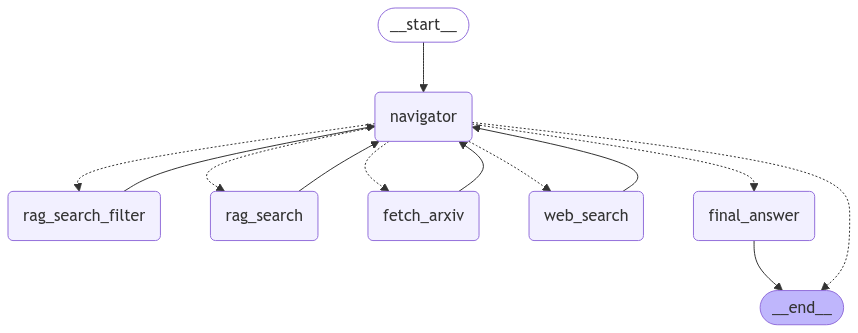

In [130]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [166]:
output = runnable.invoke({
    'input': 'Tell me something interesting about Dynamic Backtracking AI and LLMs',
    'chat_history': [],
})


run_navigator
intermediate_steps: []
rag_search.invoke(input={'query': 'Dynamic Backtracking AI'})
run_navigator
intermediate_steps: [AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='TBD'), AgentAction(tool='rag_search', tool_input={'query': 'Dynamic Backtracking AI'}, log='Title: Dynamic Backtracking\nChunk: Journal of Arti/\x0ccial In telligence Researc h /1 /(/1/9/9/3/) /2/5/-/4/6 Submitted /7///9/3/; published /8///9/3Dynamic Bac ktrac kingMatthew L/. Ginsb erg ginsber g/@cs/.uoregon/.eduCIRL/, University of Or e gon/,Eugene/, OR /9/7/4/0/3/-/1/2/6/9 USAAbstractBecause of their o ccasional need to return to shallo w p oin ts in a searc h tree/, existingbac ktrac king metho ds can sometimes erase meaningful progress to w ard solving a searc hproblem/. In this pap er/, w e presen t a metho d b y whic h bac ktrac\nArXiv ID: 9308101v1\n\n---\nTitle: Dynamic Backtracking\nChunk: /4/./2 Dynamic b acktr acking always terminates and is c omplete/. It c o

### Segment 8: Generating Formatted Reports

In [169]:
def build_report(output: dict) -> str:
    '''Builds a formatted report based on the navigator's output.

    Args:
        output (dict): A dictionary containing the various sections of the report (graph's output).

    Returns:
        str: A formatted string containing the full research report.
    '''
    research_steps = output['research_steps']
    if isinstance(research_steps, list):
        research_steps = '\n'.join([f'- {r}' for r in research_steps])
    
    sources = output['sources']
    if isinstance(sources, list):
        sources = '\n'.join([f'- {s}' for s in sources])
    
    return f"""
        INTRODUCTION
        ------------
        {output['introduction']}
        
        RESEARCH STEPS
        --------------
        {research_steps}
        
        REPORT
        ------
        {output['main_body']}
        
        CONCLUSION
        ----------
        {output['conclusion']}
        
        SOURCES
        -------
        {sources}
    """


In [171]:
output = runnable.invoke({

    'input': 'Create a summary about this AxXiv paper with the ID 2502.20384',

    'chat_history': []

})

report = build_report(

    output=output['intermediate_steps'][-1].tool_input

)

print(report)

run_navigator
intermediate_steps: []
fetch_arxiv.invoke(input={'arxiv_id': '2502.20384'})
run_navigator
intermediate_steps: [AgentAction(tool='fetch_arxiv', tool_input={'arxiv_id': '2502.20384'}, log='TBD'), AgentAction(tool='fetch_arxiv', tool_input={'arxiv_id': '2502.20384'}, log='We investigate linear matter density perturbations in the $\\Lambda_{\\rm s}$CDM, in which the $\\Lambda$ is replaced by late-time ($z\\sim2$) mirror AdS-dS transition, resulting in distinct growth dynamics. We use two complementary approaches: (i) determining the initial density contrast and its evolution rate for a given collapse scale factor, (ii) computing the collapse scale factor for a specified initial density contrast and evolution rate. We derive analytical solutions for the growth rate $f=\\Omega_{\\rm m}^\\gamma$ and growth index $\\gamma$ in both models. Prior to the transition, the AdS-like $\\Lambda$ reduces cosmic friction, causing linear matter density perturbations to grow more rapidly than